In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
import numpy as np

In [3]:
framefiles = sorted(glob('captures/*.jpg'))
print(framefiles[0])

captures\28500.jpg


In [4]:
stripfiles = sorted(glob('meshes/frame*.obj'))
stripfiles = [fl for fl in stripfiles if 't1' not in fl]
print(len(stripfiles))
print(stripfiles[0])
print(stripfiles[-1])

8170
meshes\frame28500_strip_o100_s20_704.obj
meshes\frame39000_strip_o99_s20_666.obj


In [5]:
def parsev(line, comment=True, dtype=float):
    if comment: line = line.replace('# ', '')
    parts = line.split()
    token = parts[0]
    vlist = [dtype(val) for val in parts[1:]]
    return vlist, token

parsev('# asdf 1 2 3 4')

([1.0, 2.0, 3.0, 4.0], 'asdf')

In [6]:
RSTRIDE = 3
BSTART = 40
def load_markup(fname):
    with open(fname) as fl:
        raw = fl.read()
    lines = [ln for ln in raw.split('\n') if ln]
    registers = lines[1:1+256]
    registers = [parsev(ln)[0] for ln in registers]
    
    vstart, vend, ventries = -1, -1, 1
    vstart = lines.index('# Data:') + 1
    for lii, line in enumerate(lines[vstart:]):
        if line[0] == 'v':
            ventries = lii + 1
            break
    for lii, line in enumerate(lines[vstart:]):
        if line[0] == 'f':
            vend = lii
            break
    vend += vstart
#     print(vstart, vend, ventries)
        
    vgrouped = [lines[lii:lii+ventries] for lii in range(vstart, vend, ventries)]
    faces = [parsev(ln, comment=False, dtype=int)[0] for ln in lines if ln[0] == 'f']
    
    verts = []
    for group in vgrouped:
        ent = {}
        converted = [parsev(line) for line in group[:ventries-1]]
        for vector, token in converted: ent[token] = vector
        
        vertex, _ = parsev(group[-1], comment=False)
        ent['vertex'] = vertex + [1,]
        verts.append(ent)

    for ent in verts:
        vertex = ent['vertex']
        if 'blend' in ent:
            bind = int(ent['blend'][0])
            assert bind >= 0
            boffset = BSTART + RSTRIDE * bind
            bvect = np.zeros(4)
            for dim in range(3):
                bweights = np.array(registers[boffset+dim])
                bvect[dim] = np.dot(vertex, bweights)
            bvect[3] = 1
            ent['world'] = bvect
        else:
            ent['world'] = ent['vertex']
        ent['project'] = np.array([np.dot(ent['world'], registers[rii]) for rii in range(4)])
        ent['project'] /= ent['project'][-1]

    return verts, faces, registers

verts, faces, regs = load_markup(stripfiles[0])
# verts, faces, regs = load_markup('meshes/frame30000_strip_o149_s60_2608.obj')
print(verts[0]['world'])
print(verts[-1]['world'])
print(verts[-1]['project'])
print(faces[0])

[2.61654629e+03 1.34161931e+02 7.02777690e+02 1.00000000e+00]
[2.58501141e+03 1.05473286e+02 6.96195167e+02 1.00000000e+00]
[-1.14657993 -0.38425865  0.96848487  1.        ]
[1, 1, 2]


In [93]:
def writeobj(fname, verts, faces):
    with open(fname, 'w') as fl:
#         print(len(verts))
#         assert False
        for vi, ent in enumerate(verts):
            fl.write('v %s\n' % ' '.join(['%f' % val for val in ent['world'][:3]]))
        for fi, fdef in enumerate(faces):
            
            if fi < len(faces) - 40:
                fl.write('g i%03d\n' % fi)
            fl.write('f %s\n' % ' '.join(['%d' % val for val in fdef]))

# markupfiles = sorted(glob('meshes/frame*.obj'))
# framefiles = sorted(glob('captures/*.jpg'))
# print(markupfiles[0])

# for fii, fname in enumerate(markupfiles):
#     verts, faces, regs = load_markup(fname)
#     fname = fname.replace('frame', 'blendf').replace('meshes', 'outputs')
#     writeobj(fname, verts, faces)
#     sys.stdout.write('%d/%d      \r' % (fii, len(markupfiles)))
#     sys.stdout.flush()
#     break

captures\28500.jpg
Frame 28500


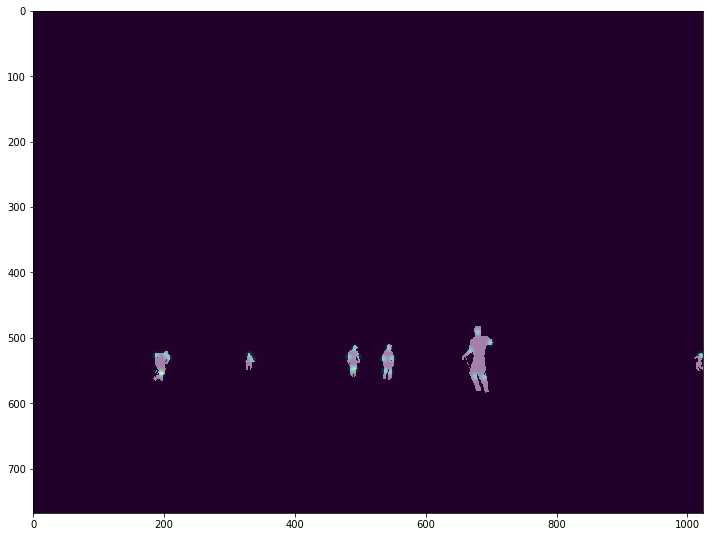

Frame 28750


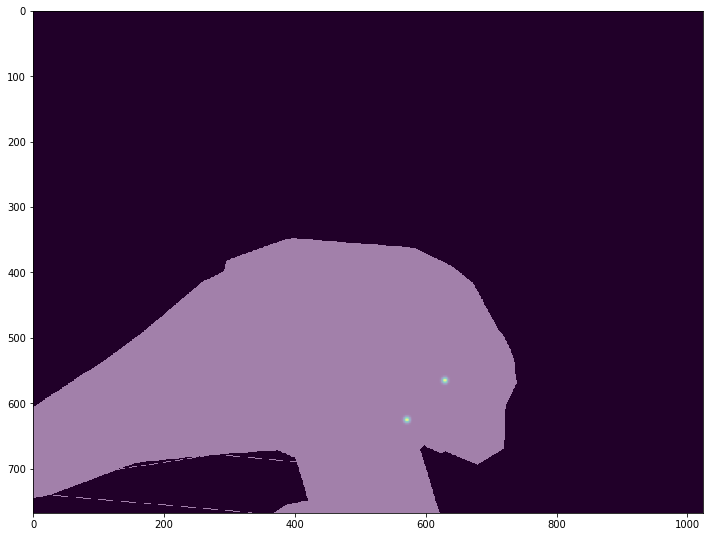

Frame 29000


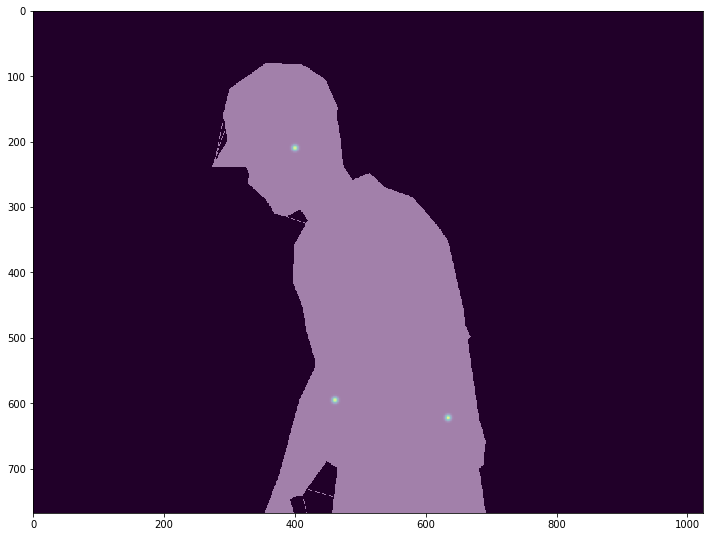

Frame 29250


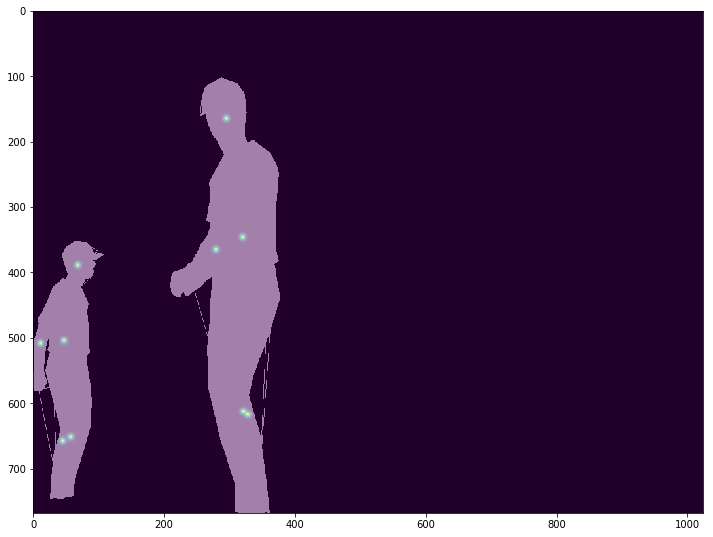

Frame 29500


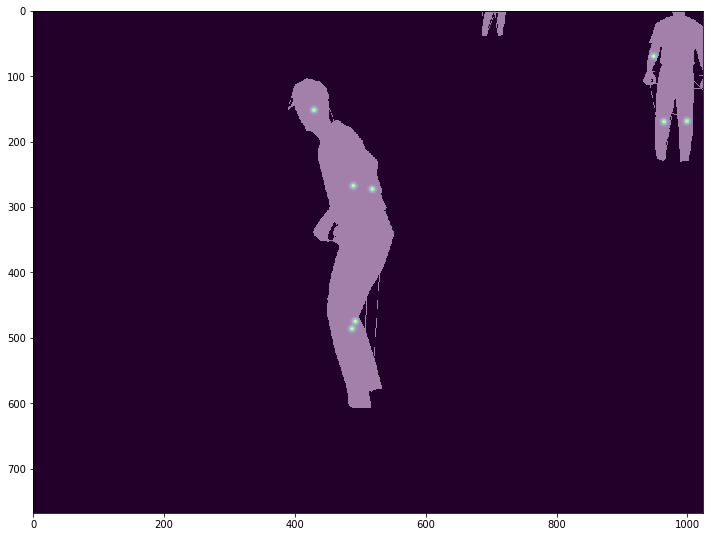

Frame 29750


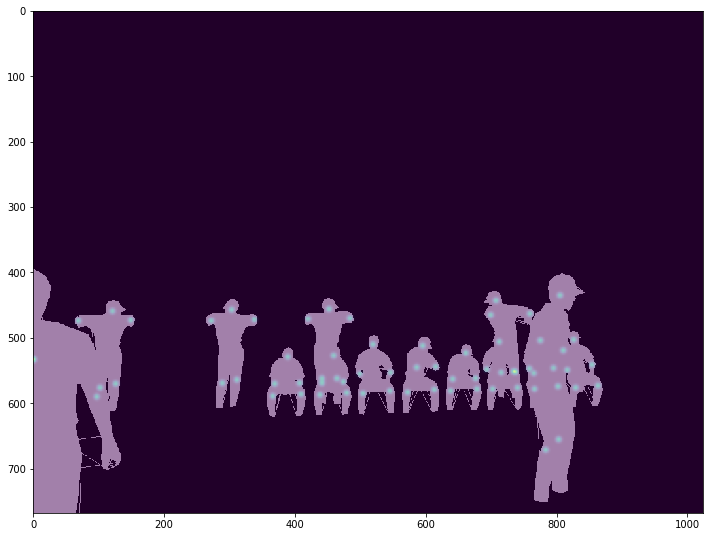

Frame 30000


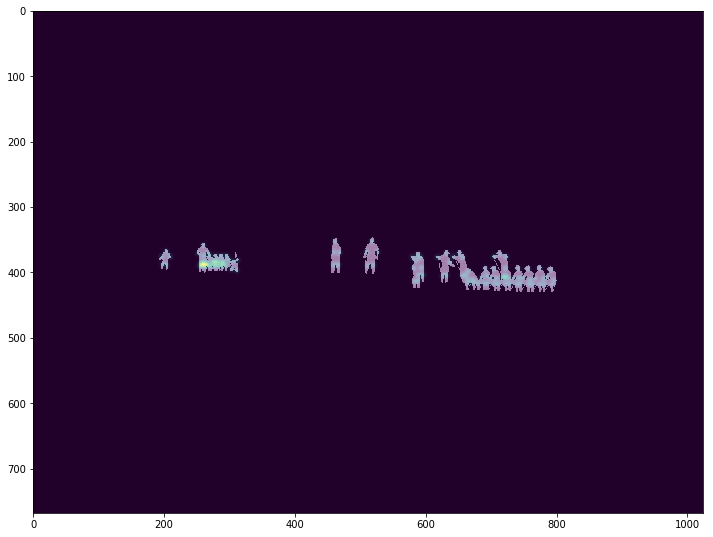

Frame 30250


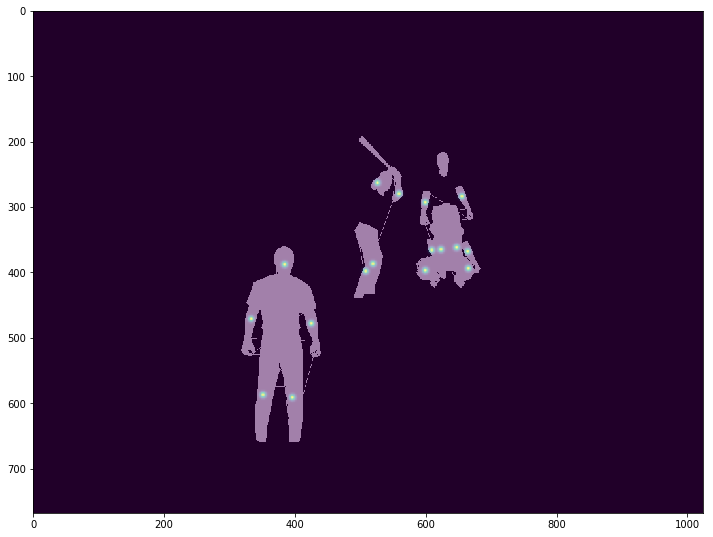

Frame 30500


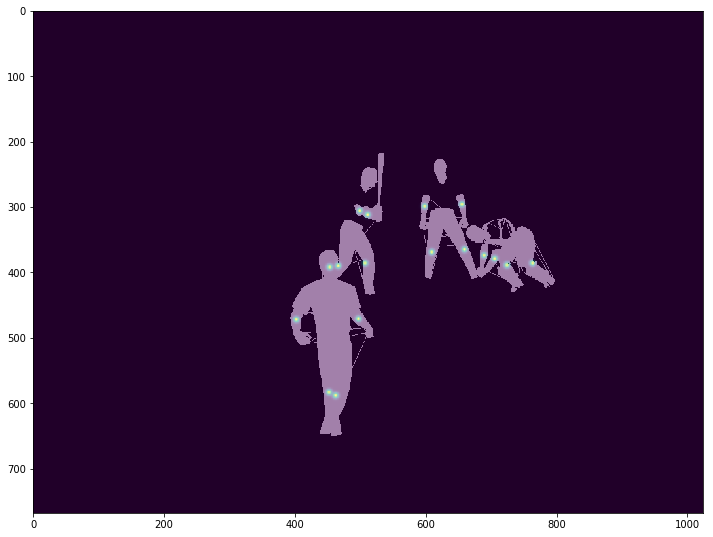

Frame 30750


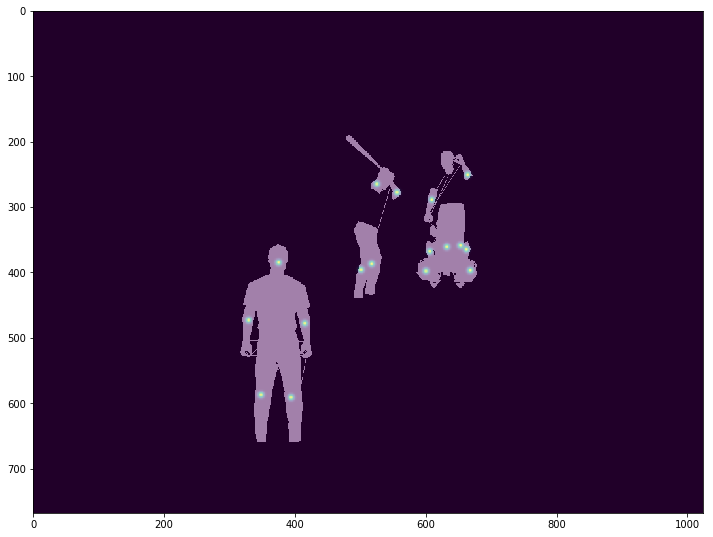

Frame 31000


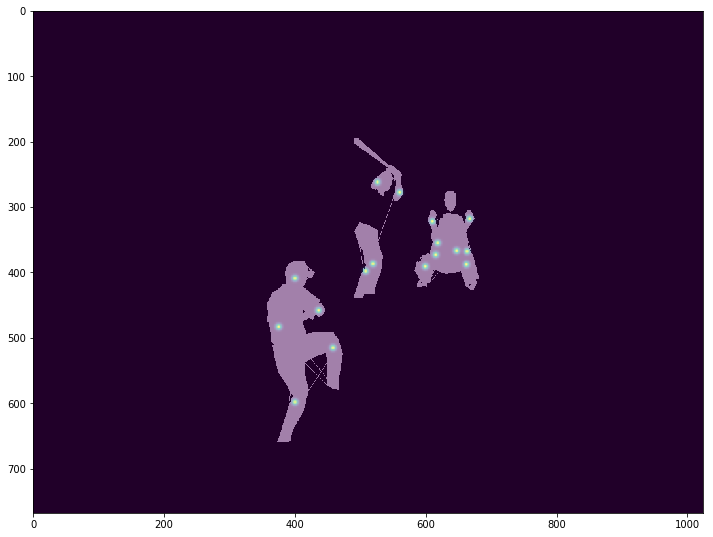

Frame 31250


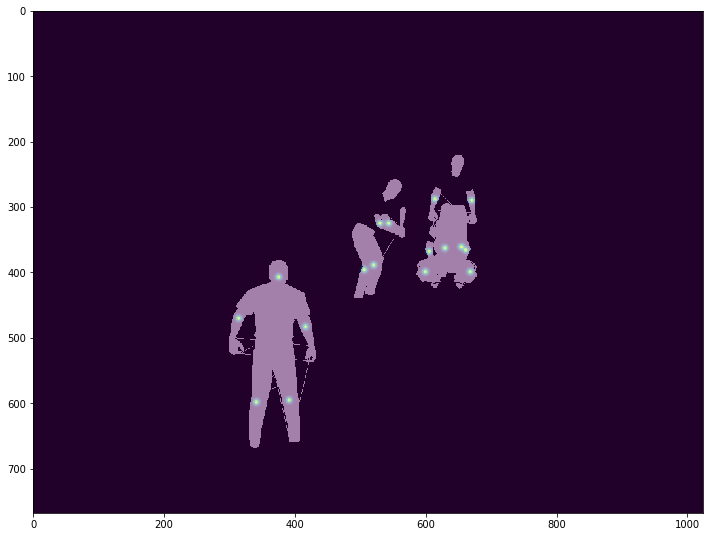

Frame 31500


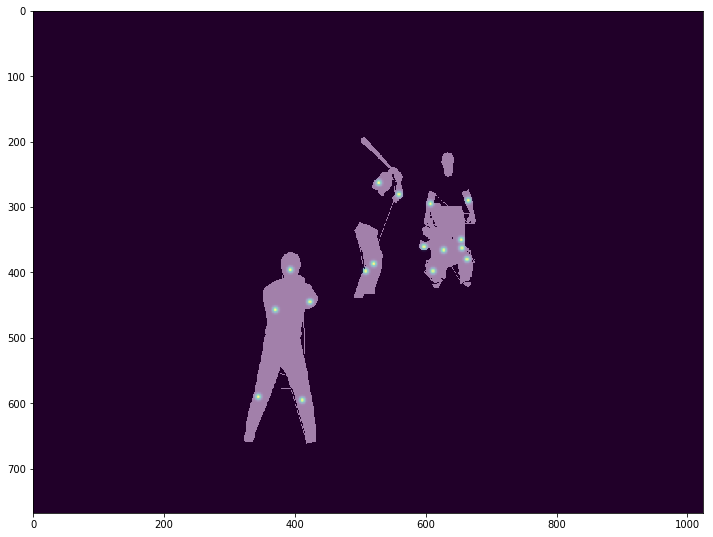

Frame 31750


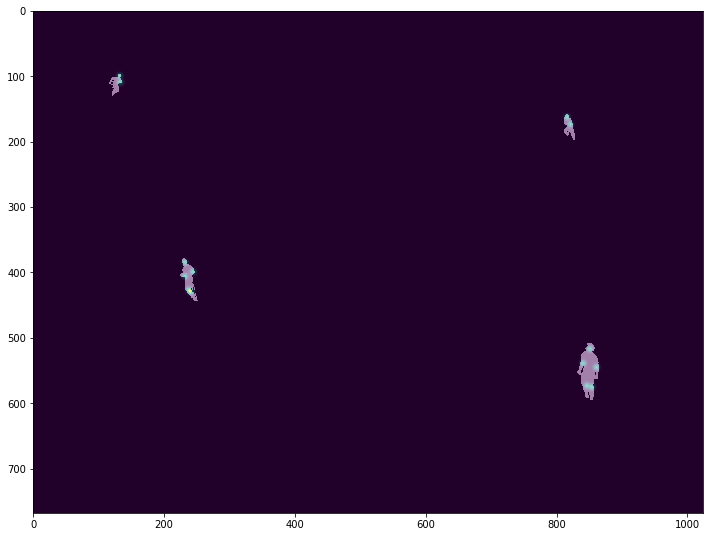

Frame 32000


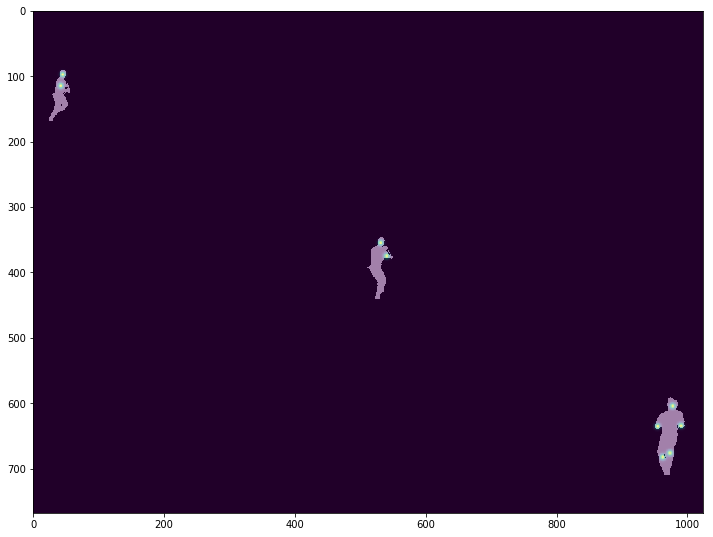

Frame 32250


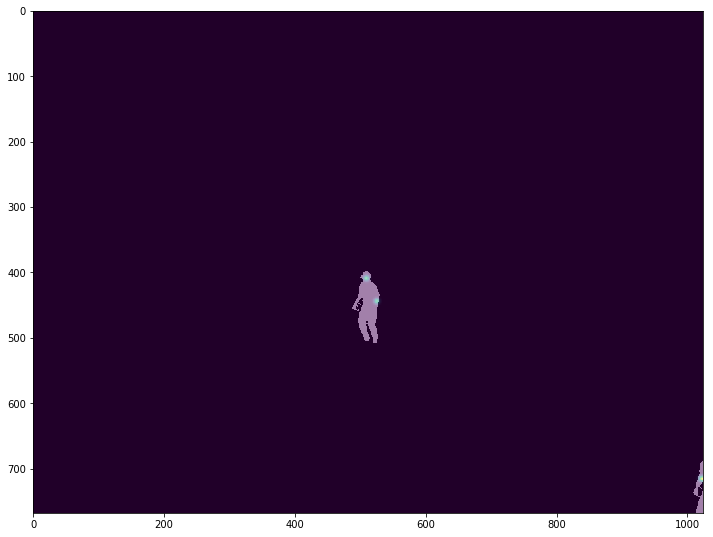

Frame 32500


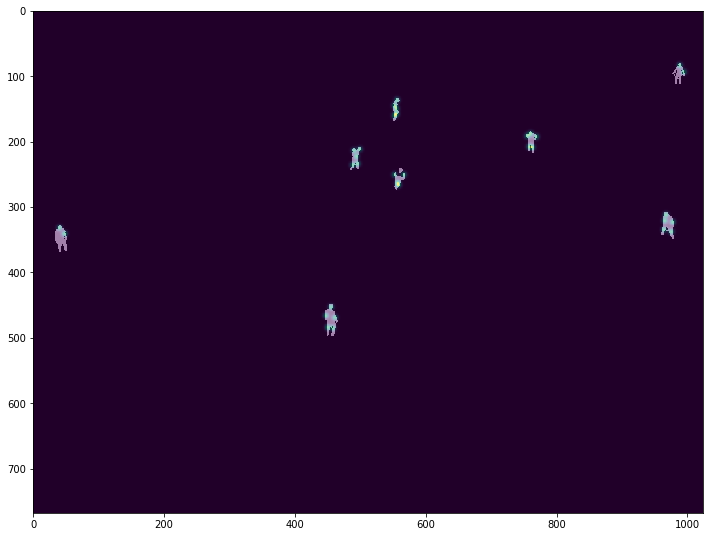

Frame 32750


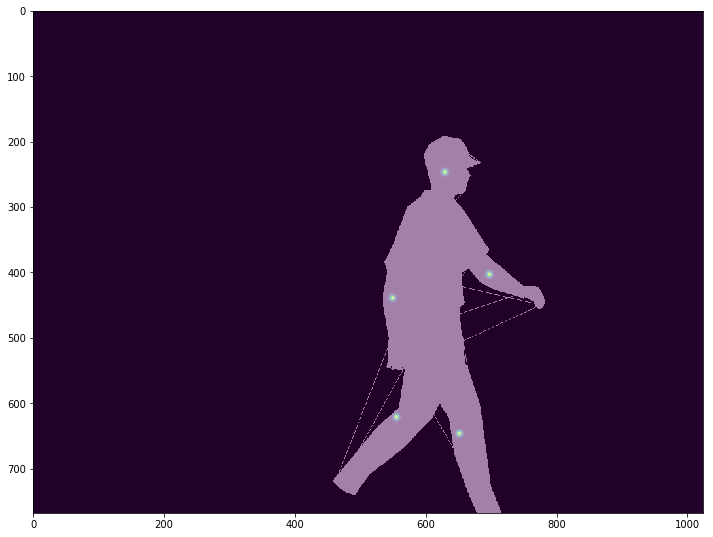

Frame 33000


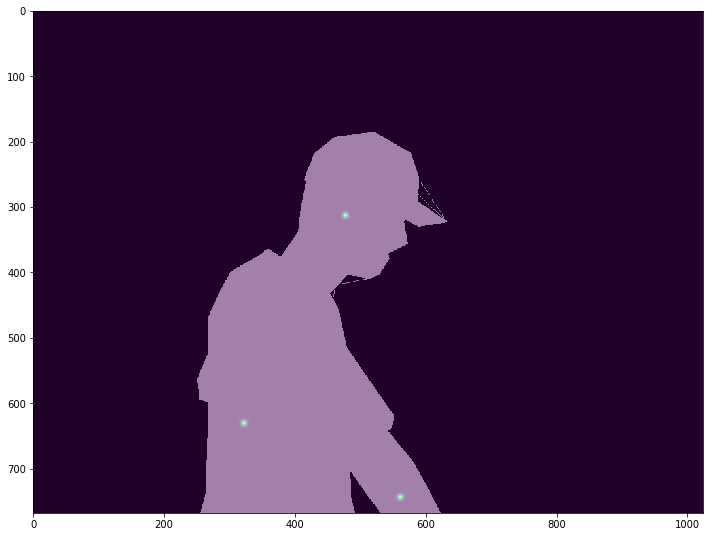

Frame 33250


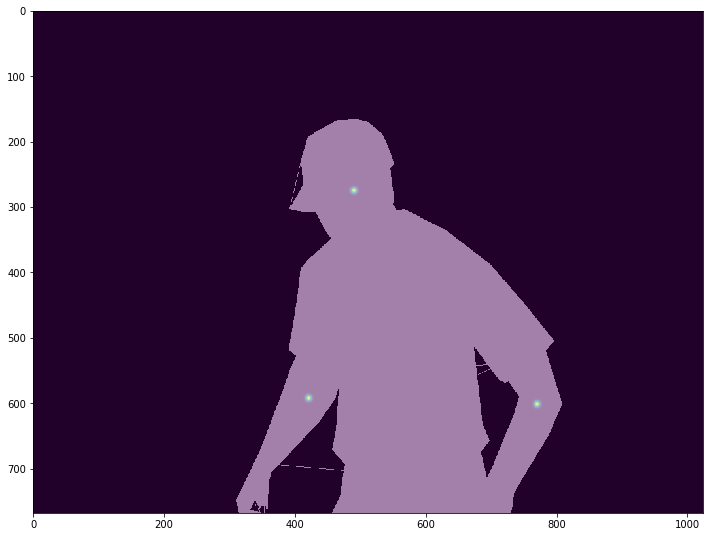

Frame 33500


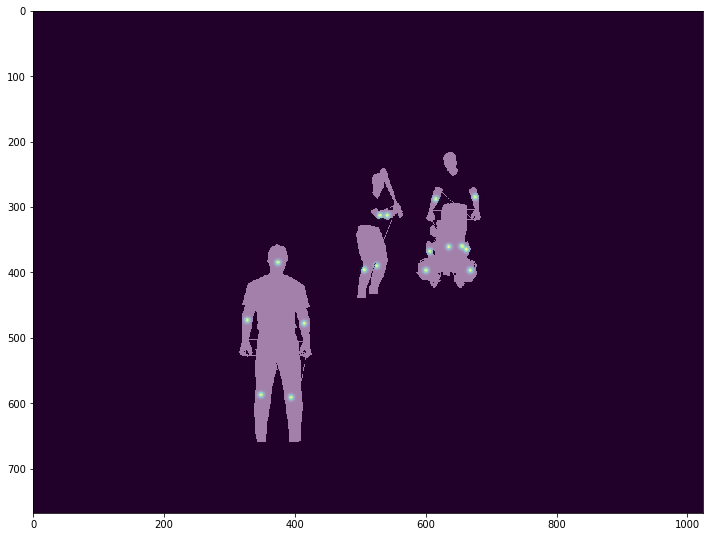

Frame 33750


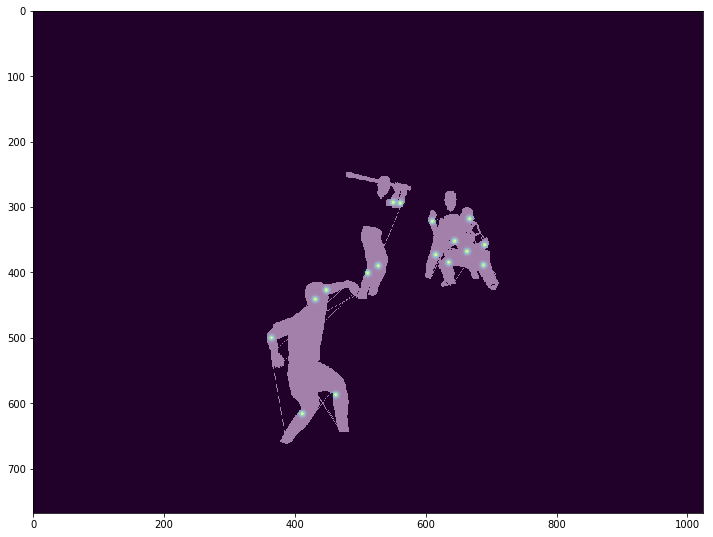

Frame 34000


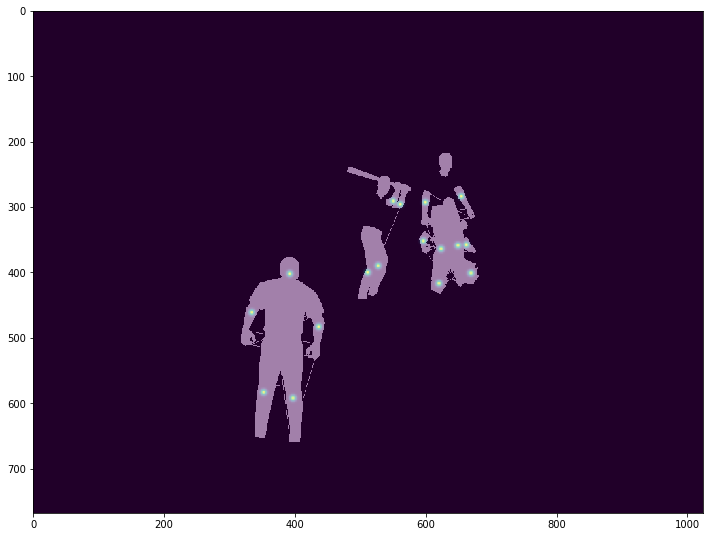

Frame 34250


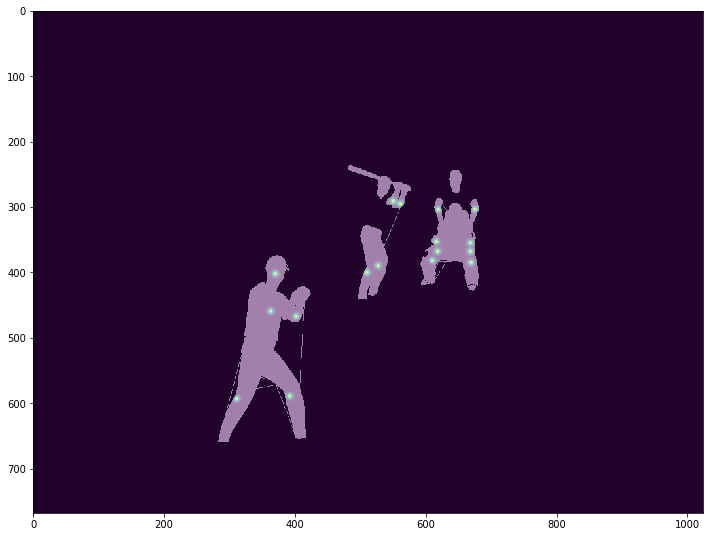

Frame 34500


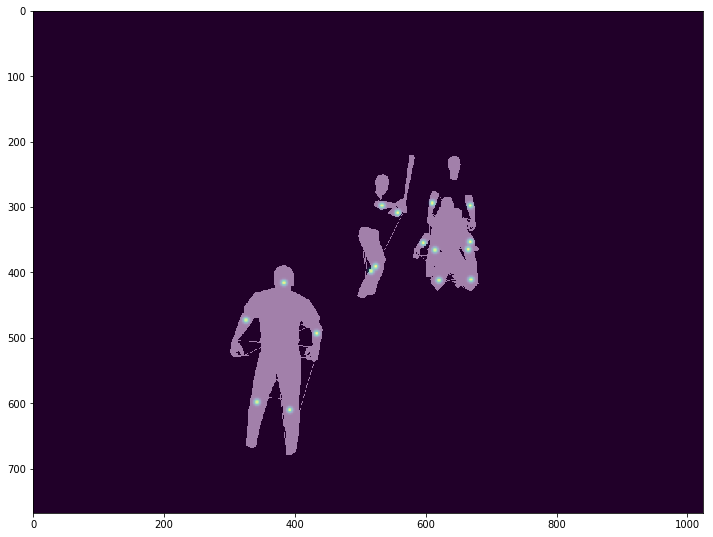

Frame 34750


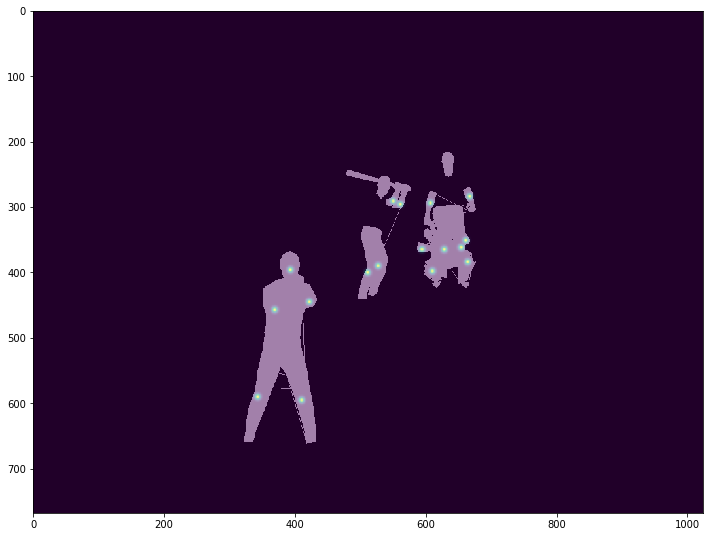

Frame 35000


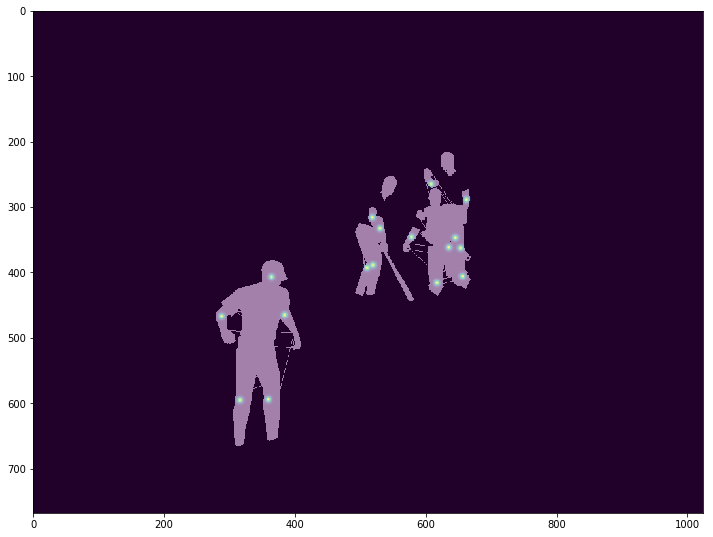

Frame 35250


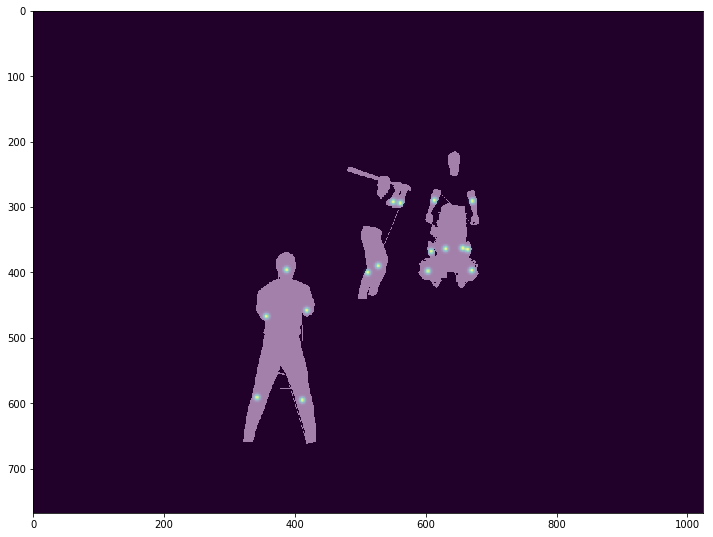

Frame 35500


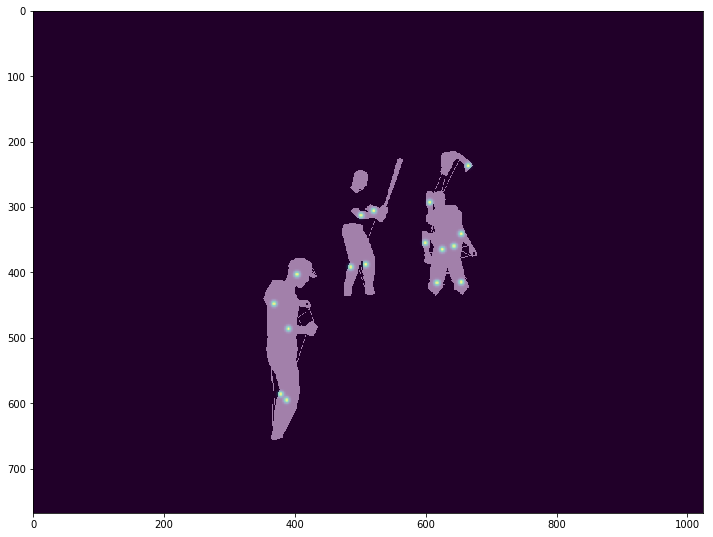

Frame 35750


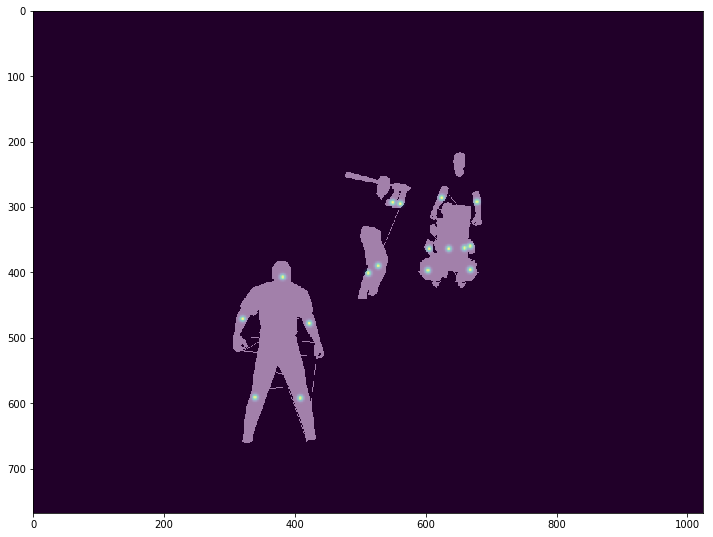

Frame 36000


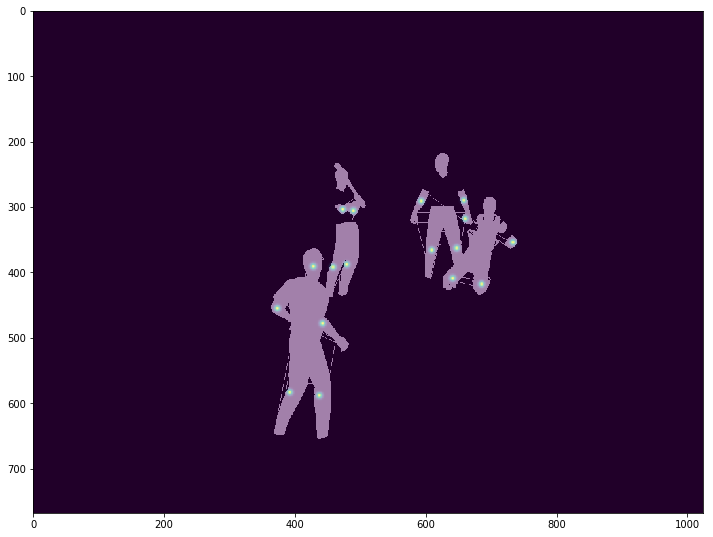

Frame 36250


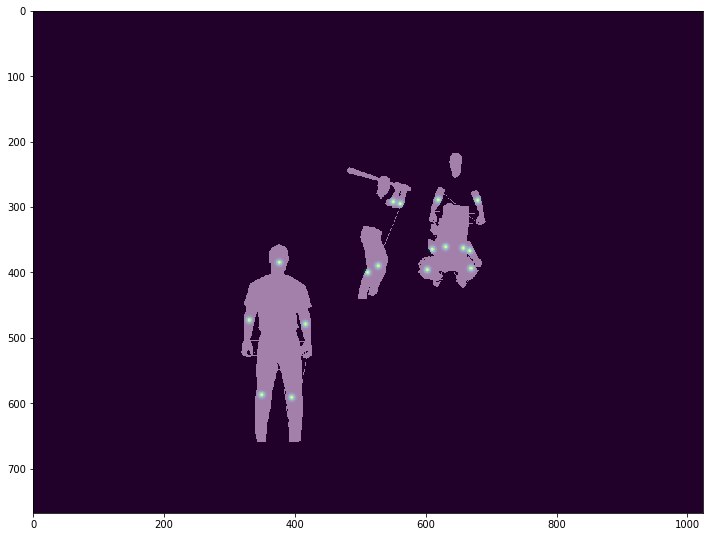

Frame 36500


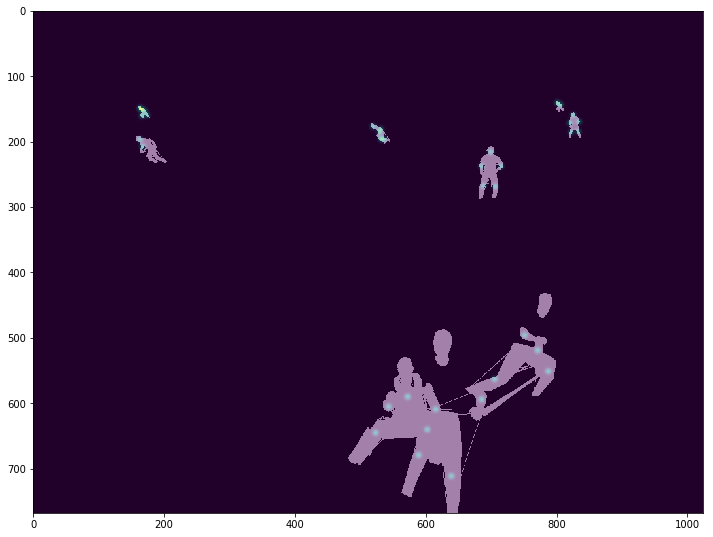

Frame 36750


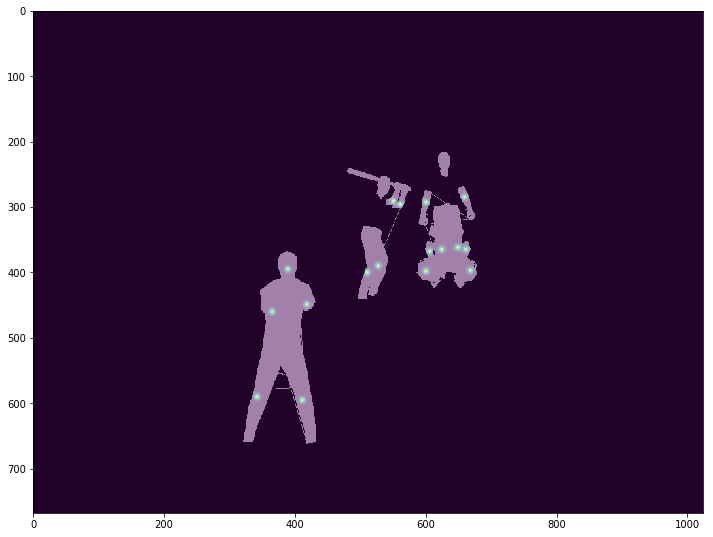

Frame 37000


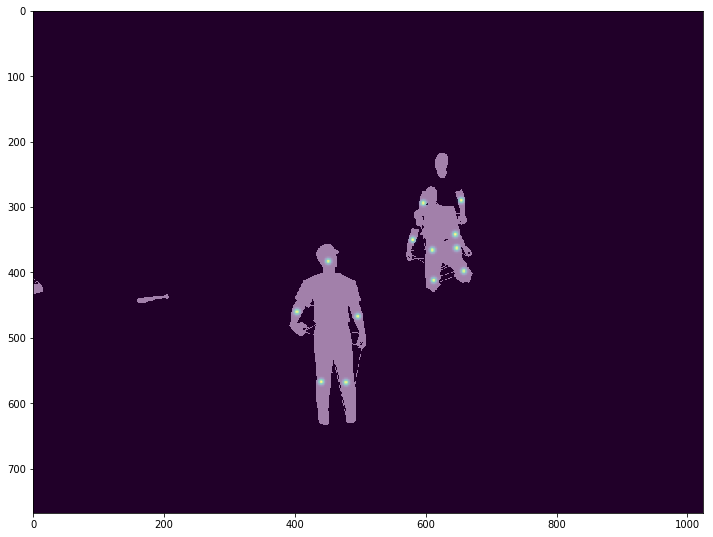

Frame 37250


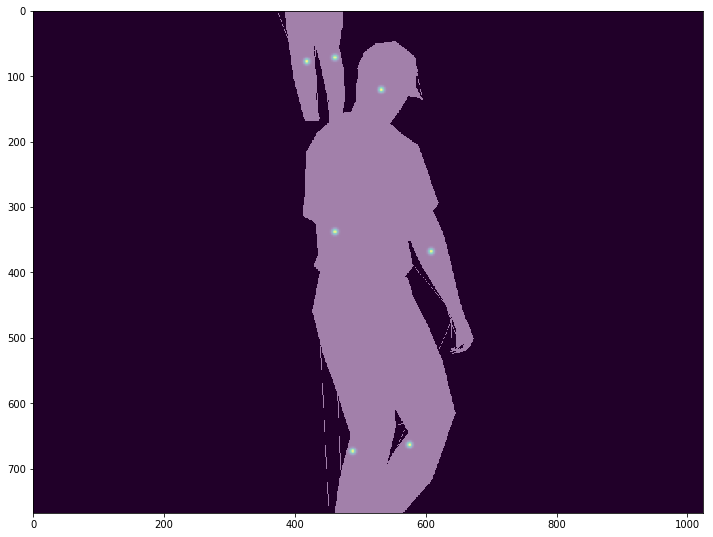

Frame 37500


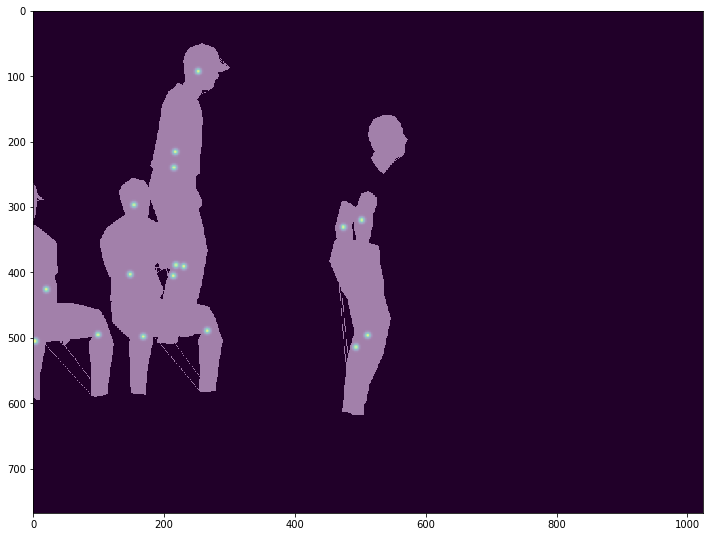

Frame 37750


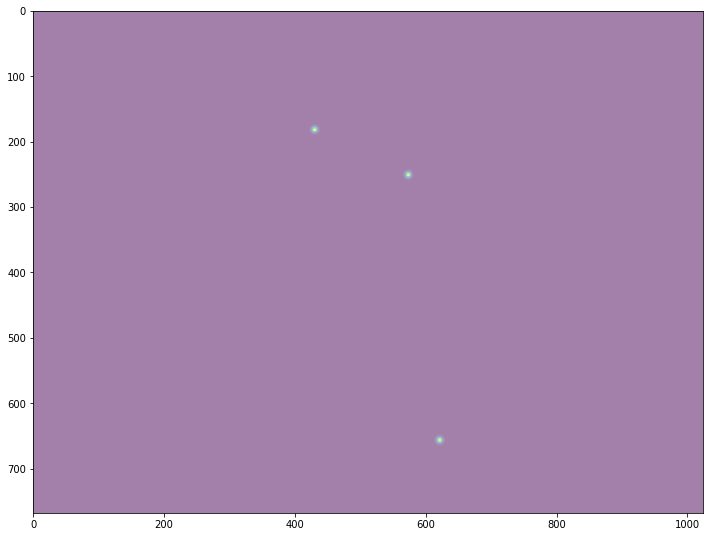

Frame 38000


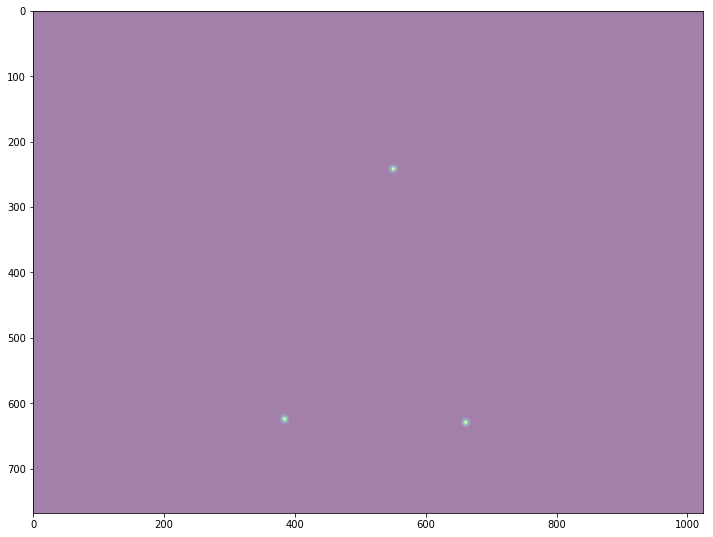

Frame 38250


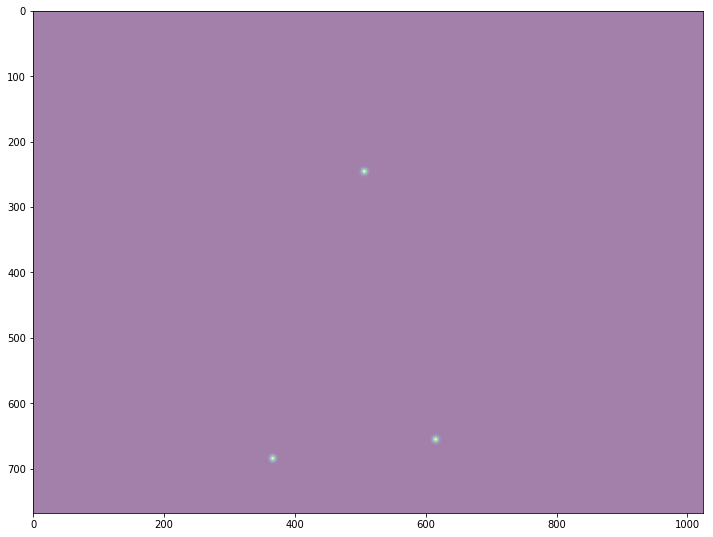

Frame 38500


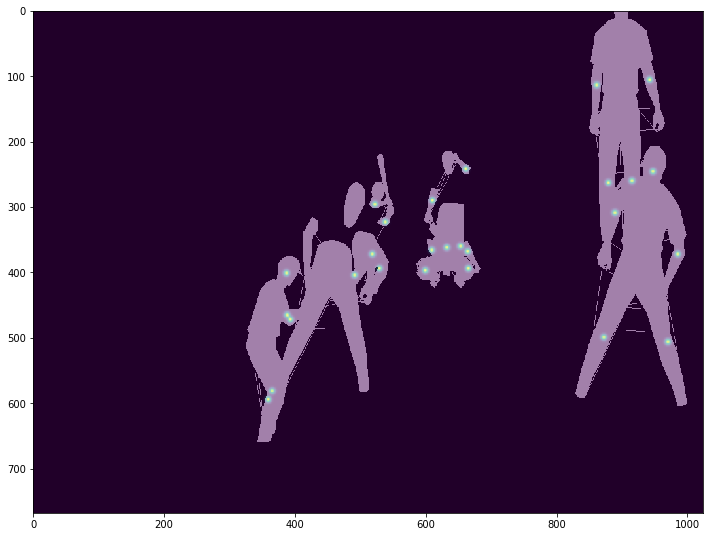

Frame 38750


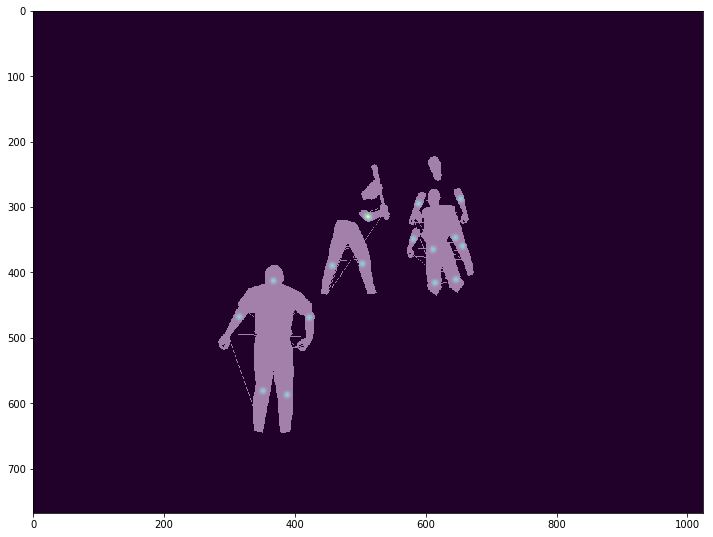

Frame 39000


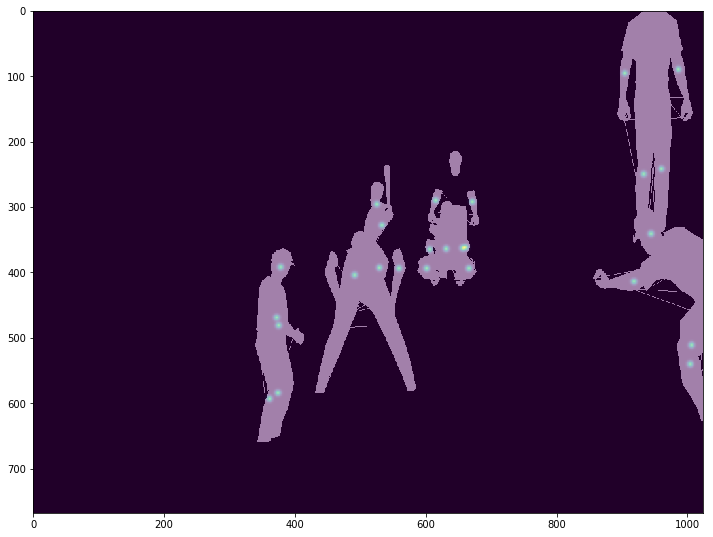

In [102]:
import matplotlib.pyplot as plt
import cv2
import sys
from scipy.ndimage import gaussian_filter as blur
    
markupfiles = sorted(glob('meshes/frame*.obj'))
framefiles = sorted(glob('captures/*.jpg'))
print(framefiles[0])

def dump_frame(fcount):
    import sys
    class merged:
        verts = []
        faces = []
    
    foffset = 0
    filtered = [fl for fl in markupfiles if '%d'%fcount in fl]
    for fii, fname in enumerate(filtered):
        verts, faces, regs = load_markup(fname)
        merged.verts += verts

        offset_faces = []
        for face in faces:
            offset_faces += [[val + foffset for val in face]]
        assert len(offset_faces) == len(faces)
        merged.faces += offset_faces

        foffset += len(verts)
        sys.stdout.write('%d/%d   \r' % (fii, len(filtered)))
        sys.stdout.flush()
        
#     raster(merged, 'raster.png')

def merge_all(merged, fname, prop):
    with open(fname, 'w') as fl:
        print('Verts', len(merged.verts))
        assert False
        for vert in merged.verts:
            fl.write('v %s\n' % ' '.join(['%f' % val for val in vert[prop][:3]]))
        for face in merged.faces:
            fl.write('f %s\n' % ' '.join(['%d' % val for val in face]))

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 0.5
fontColor              = (255,255,255)
lineType               = 1

def raster(fcount, imsize=(768, 1024)):
    canvas = np.zeros(imsize + (3,)).astype(np.uint8)
    
    filtered = [fl for fl in markupfiles if '%d'%fcount in fl]
    filtered = sorted(filtered, key=lambda val: int(val.split('_')[2][1:]))
    active_meshes = [666, 766, 326, 459, 253, 704]
    kpoints = [
#         dict(
#             name='R_Elbow',
#             match=[(0, 0)],
#             found=[],
#         ),
        dict(
            name='L_Elbow',
            match=[(704, [30, 50]), (666, [30, 50])],
            found=[],
        ),
        dict(
            name='R_Elbow',
            match=[(666, [90, 104])],
            found=[],
        ),
        dict(
            name='R_Knee',
            match=[(666, [375, 382])],
            found=[],
        ),
        dict(
            name='L_Knee',
            match=[(666, [575, 581])],
            found=[],
        ),
        dict(
            name='Head',
            match=[(766, [0, 220])],
            found=[],
        ),
        
    ]
#     assert len(parts) == len(colors)
    pcount = lambda val: int(val.split('_')[-1].replace('.obj', ''))
    cpos = lambda size, offset: size//2 + offset * size//2
#     filtered = [fl for fl in filtered if pcount(fl) in parts]
    for file_ii, fname in enumerate(filtered):
        if pcount(fname) not in active_meshes:
            continue
#         pindex = parts.index(pcount(fname))
#         color = colors[pindex]
#         order = fii / len(filtered)
#         ink = 155 + 100 * order
        verts, faces, regs = load_markup(fname)
        objname = fname.replace('frame', 'blendf').replace('meshes', 'procd')
        writeobj(objname, verts, faces)
        
        for fii, face in enumerate(faces):
            triangle = np.array([verts[vi-1]['project'][:2] for vi in face])
            triangle[:, 1] = cpos(imsize[0], -triangle[:, 1])
            triangle[:, 0] = cpos(imsize[1], triangle[:, 0])
#             triangle[:, 1] = imsize[0]//2 - triangle[:, 1] * imsize[0]//2
#             triangle[:, 0] = imsize[1]//2 + triangle[:, 0] * imsize[1]//2
            pts = triangle.reshape((-1,1,2)).astype(np.int32)
            cv2.fillPoly(canvas,[pts], [255, 255, 255])
            
            for kp in kpoints:
                for mcount, mrange in kp['match']:
                    if mcount == pcount(fname) and mrange[0] == fii:
                        
                        flist = faces[mrange[0]:mrange[1]]
                        indlist = {}
                        for tri in flist:
                            for ind in tri: 
                                indlist[ind] = True
                        coords = np.zeros((2, len(indlist)))
                        for ii, ind in enumerate(indlist.keys()):
                            coords[:, ii] = verts[ind-1]['project'][:2]
                        pnt = np.mean(coords, axis=1)
#                         kp['found'] += [(cpos(imsize[1], pnt[0]), cpos(imsize[0], -pnt[1]))]
                        kp['found'] += [(cpos(imsize[1], pnt[0]), cpos(imsize[0], -pnt[1]))]

        sys.stdout.write('%d/%d   \r' % (file_ii, len(filtered)))
        sys.stdout.flush()
    print('Frame', fcount)
    
    overlay = np.zeros(imsize)
    for kp in kpoints:
        for xx, yy in kp['found']:
            if yy >= imsize[0] or yy < 0 or xx >= imsize[1] or xx < 0:
                continue
            overlay[int(yy), int(xx)] = 255
    overlay = blur(overlay, 3)
    overlay /= np.max(overlay)
        
    plt.figure(figsize=(12, 10))
    plt.imshow(canvas)
    plt.imshow(overlay, alpha=0.5)
#     cv2.imwrite('outputs/%d_mask.png' % fcount, cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
#     cv2.imwrite('outputs/%d_points.png' % fcount, (overlay * 255).astype(np.uint8))
    cap = cv2.imread('captures/%d.jpg' % fcount)
    cap = cap.astype(np.float32) * 0.25
    cap = cap[30:-10]
    cap[:, :, 2] += overlay * 255 * 0.75
    
    
    text_layer = np.zeros(cap.shape, dtype=np.uint8)
    for kp in kpoints:
        for xx, yy in kp['found']:
            if yy >= imsize[0] or yy < 0 or xx >= imsize[1] or xx < 0:
                continue
            cv2.putText(text_layer, kp['name'].lower(), 
                (int(xx), int(yy)), 
                font, 
                fontScale,
                fontColor,
                lineType)
            
    cap = cap * 0.75 + text_layer.astype(np.float32) * 0.25
    cap = cap.astype(np.uint8)
    cv2.imwrite('outputs/%d_overlay.png' % fcount, cap)
    plt.show()
    plt.close()

for fname in framefiles:
    raster(int(fname.split('\\')[-1][:-4]))
#     break